In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import json
import sklearn
from sklearn import * 
from pytorch_v2 import TorchGame
from matplotlib import pyplot as plt
from matplotlib import cm
import torch
import numpy as np
import random, math, os

params_test = {
        "Horizon": 3, "Max_actions_chosen": 2, "N_actions_startpoint": 8, "I": .5, "D": 5,
        "Players_action_length": [5, 5], "Max_optim_iter": 75, "Filter_actions": True,
        "Stochastic_state_update": True, "base_params": "paper", "NumRepsBattle": 8,
        "DEVICE": "cpu", "MultiProcess": False
    }

game = TorchGame(**params_test)
pkl_path = "saved_runs/smallRun_smallVarXi/History.pkl"
df = pd.read_pickle(pkl_path)
df = df.loc[:,:]

df.State[0] = game.flatten_var(torch.tensor(game.InitialState.tolist())).numpy()



          PlayerA_y  PlayerB_y
sen_tec           4          4
col_sys           2          2
tec_mob           3          3
cont_alg          5          5
loc_map           3          3
sen_fus           3          3
ai_ml             2          2
edg_com           2          2
com_net           4          4
ene_mgm           4          4
sim_mod           2          2
hum_man           3          3
cyb_sec           3          3
eth_reg           2          2
          sen_tec  col_sys  tec_mob  cont_alg  loc_map  sen_fus  ai_ml   
A,B             0        0        0         0        0        0      0  \
Phi, Psi        9        3        1         3        3        9      3   
n_a,n_b         3        3        1         3        1        3      9   
p_a,p_b         9        1        1         3        9        3      1   
n_y,n_z         9        9        9         3        3        9      3   
p_y,p_z         9        3        3         3        3        3      9   
u,v             0

C:\Users\IsakG\AppData\Local\Temp\ipykernel_19600\1951030428.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.State[0] = game.flatten_var(torch.tensor(game.InitialState.tolist())).numpy()


In [2]:
techNames = game.TechnologyNames
techNames = ["_".join([x.capitalize() for x in s.split("_")]) for s in techNames]
techNamesFull = ["Sensor technologies", "Collaborative systems", "Technologies enabling mobility", "Control systems & algorithms", "Localisation & mapping", "Sensor fusion",
                 "AI & machine learning", "Edge computing", "Communications & networking", "Energy management", "Simulation & modelling",
                 "Human machine interaction", "Cybersecurity", "Ethics & regulations"]

techNamesFullBroken = ["Sensor technologies", "Collaborative systems", "Technologies \n enabling mobility", "Control systems & \n algorithms", "Localisation & \n mapping", "Sensor fusion",
                 "AI &\n machine learning", "Edge computing", "Communications &\n networking", "Energy management", "Simulation &\n modelling",
                 "Human machine \n interaction", "Cybersecurity", "Ethics &\n regulations"]

paramNames = ["$"+PN.replace(",",", ")+"$" for PN in game.ParamNames]
paramNames[1] = "$\phi, \psi$"
paramNames


['$A, B$',
 '$\\phi, \\psi$',
 '$n_a, n_b$',
 '$p_a, p_b$',
 '$n_y, n_z$',
 '$p_y, p_z$',
 '$u, v$',
 '$w, x$']

In [3]:
def  plot_or_show(fig,fileName, dir=None):
    if fileName is not None:
        if dir is not None:
            path = os.path.join(os.getcwd(),"figures", dir, fileName)+".pdf"
        else:
            path = os.path.join(os.getcwd(),"figures",  fileName)+".pdf"
        
        print(path)
        # with open(path,"w+") as f:
        plt.savefig(path, format = "pdf")
    else:
        fig.show()
        fig.tight_layout(pad=3)
        
# fig,ax = plt.subplots(1,1)
# ax.scatter(np.random.randn(100),np.random.randn(100))
# plot_or_show(fig, "test")

In [4]:
techNames

['Sen_Tec',
 'Col_Sys',
 'Tec_Mob',
 'Cont_Alg',
 'Loc_Map',
 'Sen_Fus',
 'Ai_Ml',
 'Edg_Com',
 'Com_Net',
 'Ene_Mgm',
 'Sim_Mod',
 'Hum_Man',
 'Cyb_Sec',
 'Eth_Reg']

In [5]:
# print(df.columns)
# if (df["Reward"]==0).all():
  
#     numReps = 20
#     states = df["State"]
#     states = [game.stack_var(torch.tensor(st, dtype=torch.double)) for st in states.values.tolist()]
#     thetas = [game.techToParams(st) for st in states]
#     scores = [np.mean([game.SalvoBattleSequential(th).numpy() for _ in range(numReps)]) for th in thetas]
#     scores = scores
#     print(scores)
#     df["Reward"] = scores
#     df.to_pickle(pkl_path)
# else:
#     print("df aldready contained scores")
# # df["Reward"] = game.SalvoBattleSequential(game.techToParams()

In [6]:
df.Reward

0      0
1      0
2      0
3      0
4      0
      ..
96     0
97     0
98     0
99     0
100    0
Name: Reward, Length: 101, dtype: int64

In [7]:
print(df.Action[1].shape,
    df.State[0].shape)

(28,) (28,)


In [8]:
# print(df.State[0])
# tmp = np.concatenate((df.State[0][:,0],df.State[0][:,1]),0)
# print(tmp)
# print(df.State[13])

# df.State[1] = tmp

In [9]:
plt.style.use('bmh')
# plt.rcParams["figure.facecolor"] = "D1E2FF"
# plt.rcParams["axes.facecolor"] = "F2F8FF"
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times new roman"]
# display(plt.rcParams.keys())

In [10]:
nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
print(nParams, nTech)

8 14


In [11]:
def plot_trl(old_state, new_state, title, fileName = None):
    nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
    print(nParams, nTech)
    

    old_state_A = old_state[:nTech]
    new_state_A = new_state[:nTech]
    
    old_trl_A = game.TechnologyReadiness(old_state_A).numpy()
    new_trl_A = game.TechnologyReadiness(new_state).numpy()

    
    old_state_B = old_state[nTech:]
    new_state_B = new_state[nTech:]
    
    old_trl_B = game.TechnologyReadiness(old_state_B).numpy()
    new_trl_B = game.TechnologyReadiness(new_state_B).numpy()
        
    state_grid = np.linspace(-1,12,1000)
    trl_base = game.TechnologyReadiness(torch.tensor(state_grid)).numpy()
    
    
    # fig.suptitle(title,  fontsize="xx-large")
    for i in range(nTech):
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7,4)
        k = i
        # print(i,j,"-",k)
        # print(r,c)
        ax.plot(state_grid, trl_base)
        #otes
        ax.scatter(old_state_A[k].numpy(), old_trl_A[k], color="blue", alpha = .5, label ="Player A previous value")
        ax.scatter(old_state_B[k].numpy(), old_trl_B[k], color="red", alpha = .5, label ="Player B previous value")
        #nes
        ax.scatter(new_state_A[k].numpy(), new_trl_A[k], color="blue", alpha = 1, label ="Player A new value")
        ax.scatter(new_state_B[k].numpy(), new_trl_B[k], color="red", alpha = 1, label ="Player B new value")
        ax.set_title(techNamesFull[k])
        ax.legend()
        ax.set_xlabel
            
            
            
        
        plot_or_show(fig, fileName+"_"+str(i), "TRL")
    # if fileName is not None:
    #     fig.savefig(os.path.join("figures", fileName, ".pdf"), format = "pdf")
    # else:
    #     fig.show()
    #     fig.tight_layout(pad=3)
    
def plot_act_theta(state, action, state_id, fileName = None):
    nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
    
    action = game.stack_var(action)
    theta = game.techToParams(game.stack_var(state))
    
    theta_A = theta[:,0].numpy()
    action_A = action[:,0].numpy()
   
    theta_B = theta[:,1].numpy()
    action_B = action[:,1].numpy()
    
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(14,4)
    # fig.suptitle(title)
    
    width = .5
    r = np.arange(nTech)
    axs[0].set_title(f"Actions of each player in sampled state")
    axs[0].bar(r, action_A, color="blue", width= width, label="Player A")
    axs[0].bar(r+width, action_B, color="red", width= width, label="Player B")
    # axs[1].xticks(r + width/2 , labels = game.ParamNames)
    axs[0].set_xticks(r + width/2)
    axs[0].set_xticklabels(labels = techNames)
    axs[0].legend()
    
    
    
    # width = .5
    r = np.arange(nParams)
    axs[1].set_title(f"Battle Parameters of each player in sampled state")
    axs[1].bar(r, theta_A, color="blue", width= width, label="Player A")
    axs[1].bar(r+width, theta_B, color="red", width= width, label="Player B")
    # axs[1].xticks(r + width/2 , labels = game.ParamNames)
    axs[1].set_xticks(r + width/2)
    axs[1].set_xticklabels(labels = paramNames)
    axs[1].legend()



    fig.autofmt_xdate()

    
    plot_or_show(fig, fileName, None)
    
#     if fileName is not None:
        
#         fig.savefig(os.path.join("figures", fileName, ".pdf"), format = "pdf")
#     else:
#         fig.show()
#         # fig.tight_layout(pad=3)

#     # fig.show()
    
    
# # df.Action[9]

In [12]:
# df[df.Node_id == 0].State.values

Index(['Node_id', 'Parent_id', 'Time', 'State', 'Action', 'Reward'], dtype='object')
4.0
c:\Users\IsakG\projects\exjobb\figures\actionTheta.pdf


C:\Users\IsakG\AppData\Local\Temp\ipykernel_19600\3352582769.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  old_state =  torch.tensor(df[df.Node_id == p_id].State.values.tolist()).squeeze()


8 14
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_0.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_1.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_2.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_3.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_4.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_5.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_6.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_7.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_8.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_9.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_10.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_11.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_12.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_onestep_13.pdf


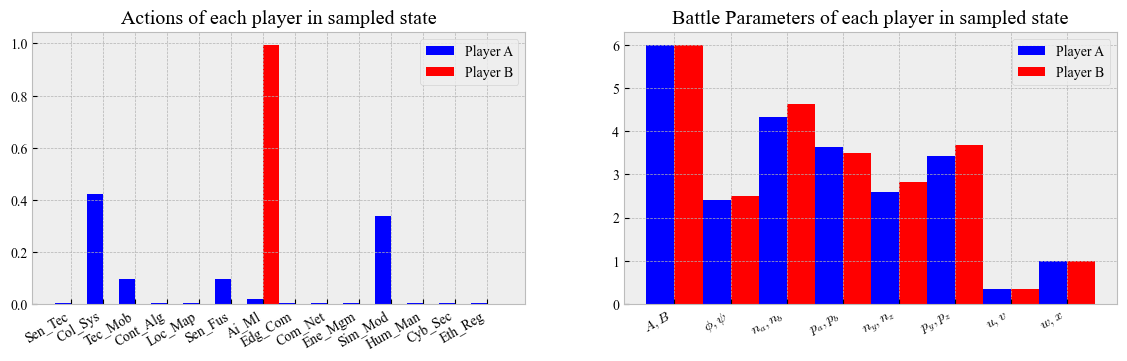

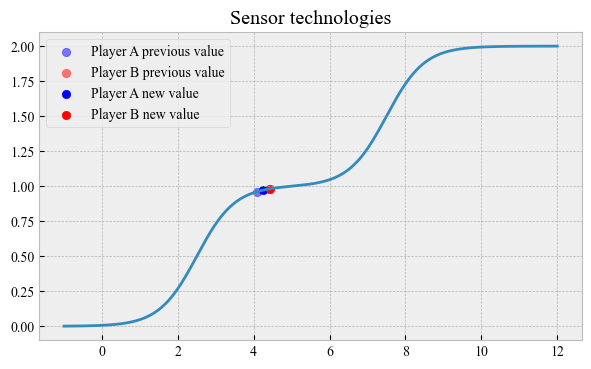

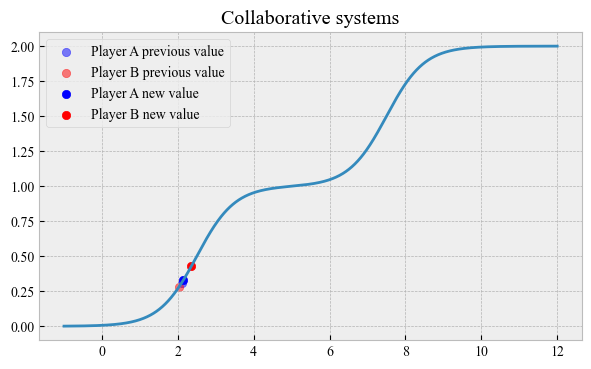

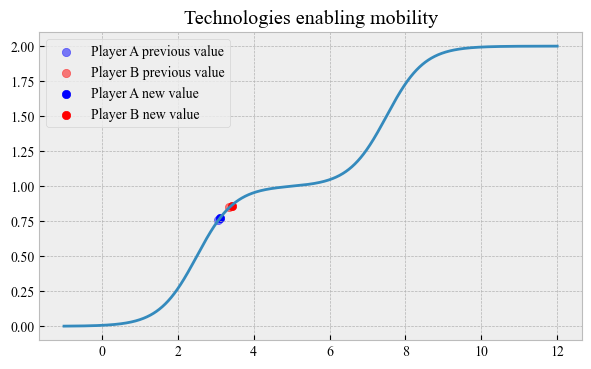

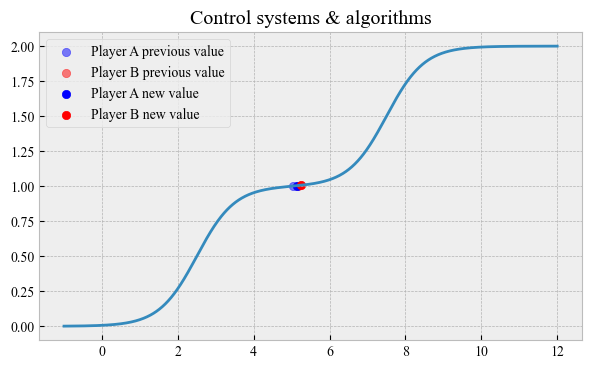

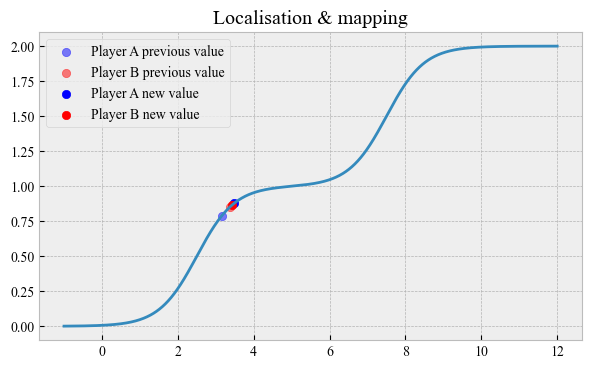

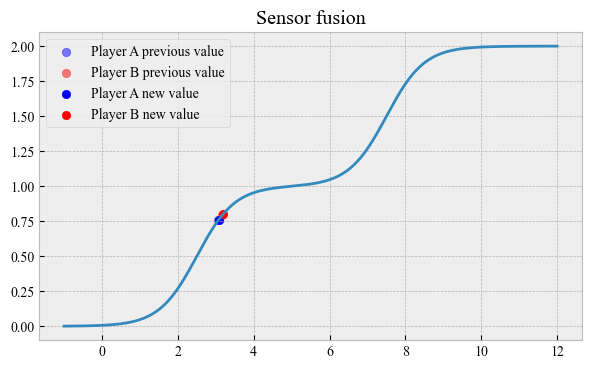

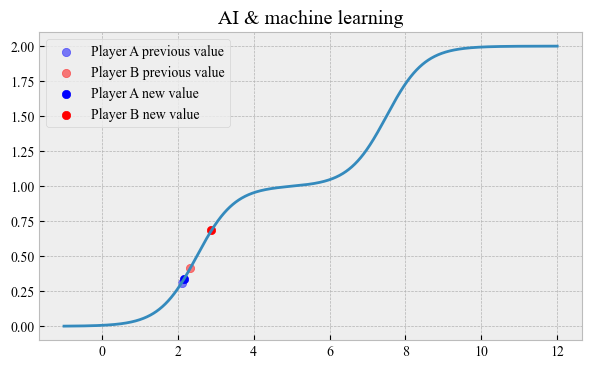

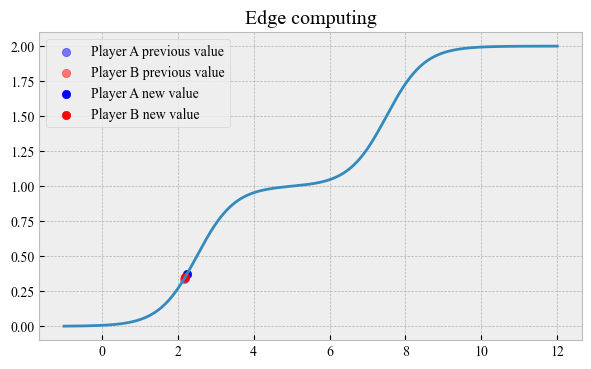

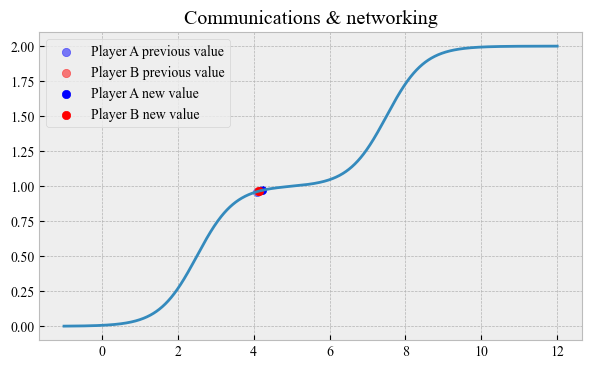

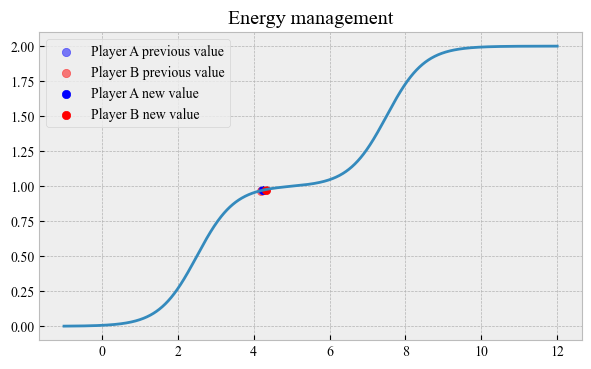

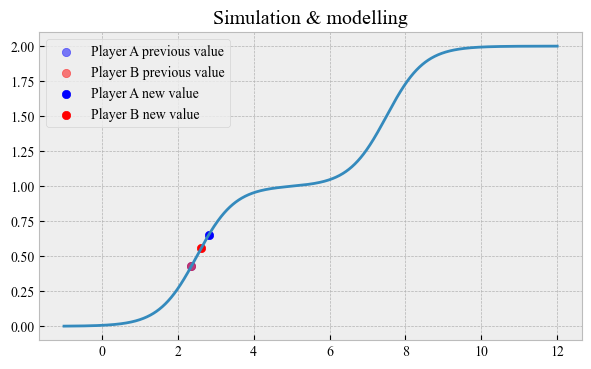

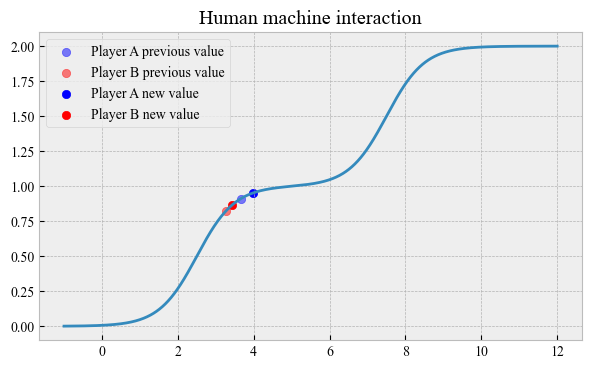

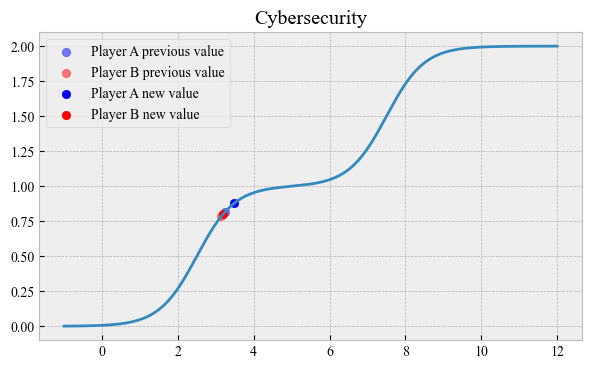

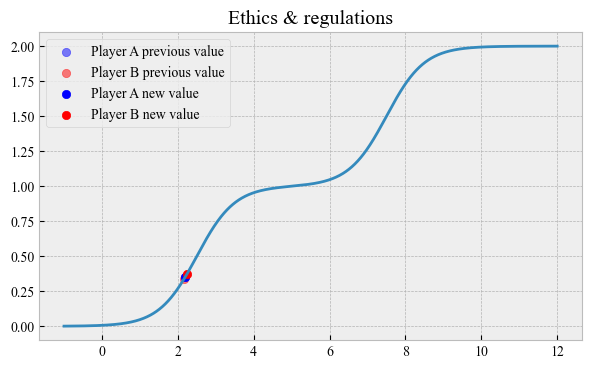

In [13]:

print(df.columns)
numPoints = len(df.index)
old_state_i = df.Parent_id
states =df.State
actions = df.Action

plot_ind = 5

p_id = df.loc[plot_ind,:].Parent_id
print(p_id)
old_state =  torch.tensor(df[df.Node_id == p_id].State.values.tolist()).squeeze()

new_state =  torch.tensor(states[plot_ind]).squeeze()

act = torch.tensor(actions[plot_ind]).squeeze()
plot_act_theta(new_state, act, plot_ind, "actionTheta")
plot_trl(old_state,new_state, "Technology research progress in one timestep", "TRL_onestep")



In [14]:
leaf_nodes = df[df.Time == df.Time.max()].Node_id.values

Index(['Node_id', 'Parent_id', 'Time', 'State', 'Action', 'Reward'], dtype='object')
[  9  10  11  12  18  19  20  21  22  23  24  25  26  27  28  29  30  31
  36  37  38  39  43  44  45  46  47  48  49  57  58  59  60  63  64  65
  66  67  68  69  73  74  75  76  77  78  79  80  85  86  87  88  89  90
  91  94  95  96  97  98  99 100]
8 14
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_0.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_1.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_2.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_3.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_4.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_5.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_6.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_7.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_8.pdf
c:\Users\IsakG\projects\exjobb\figures\TRL\TRL_fullGame_9.pdf
c:\Users\IsakG\projects\exjobb\figure

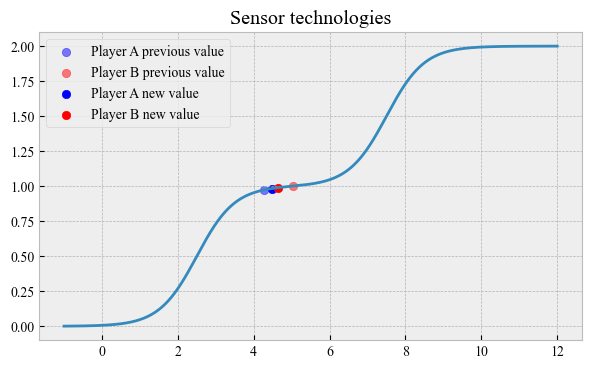

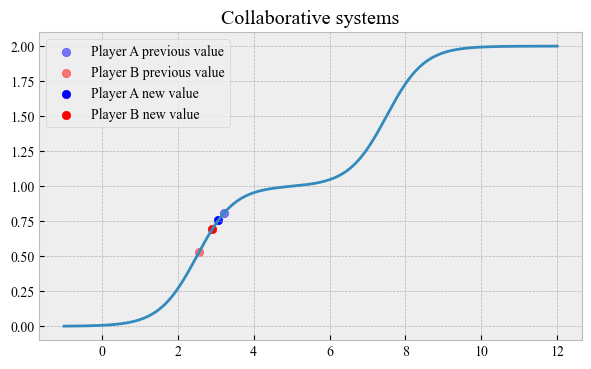

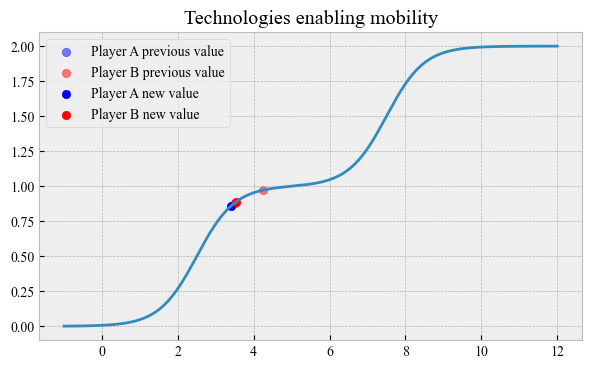

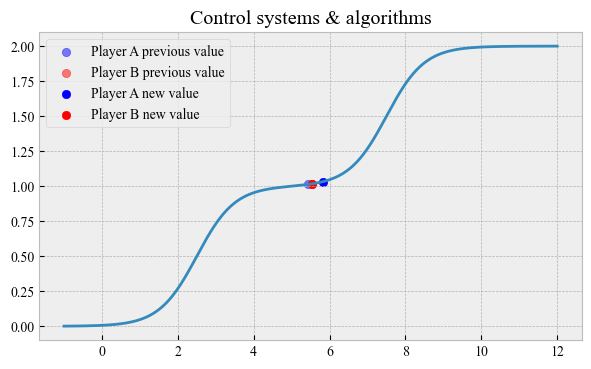

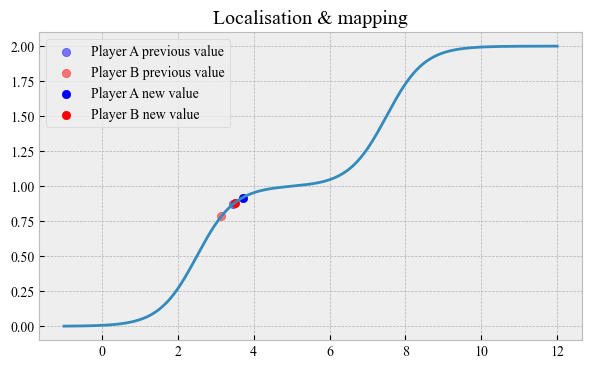

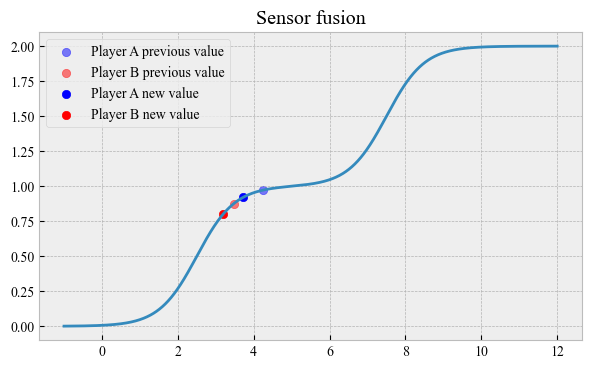

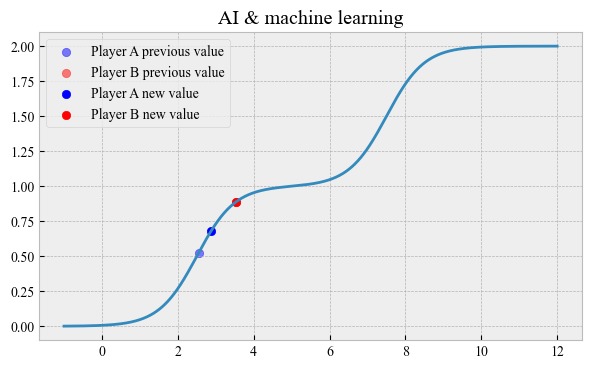

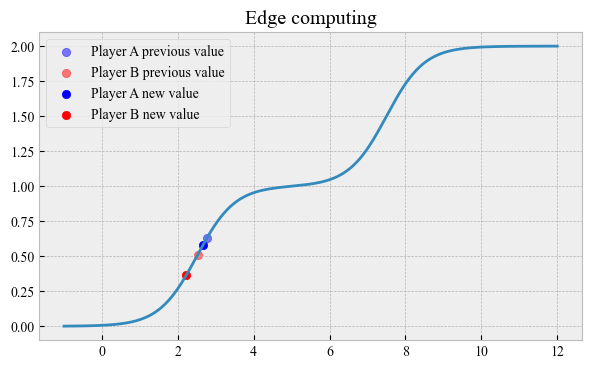

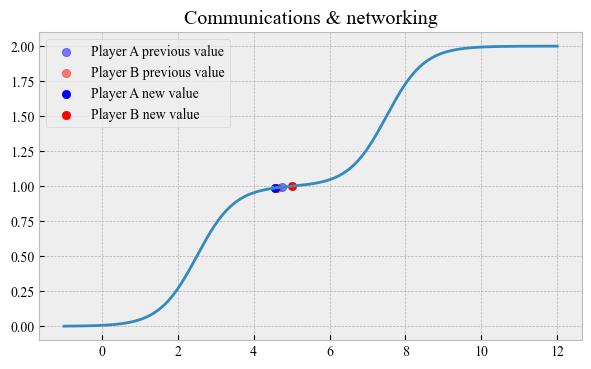

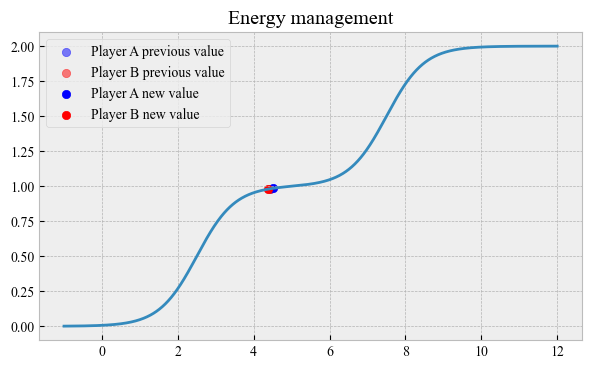

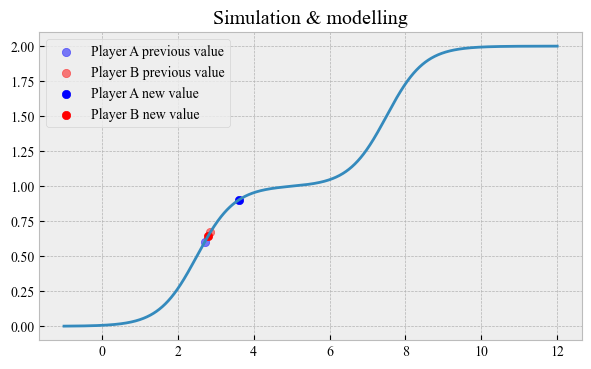

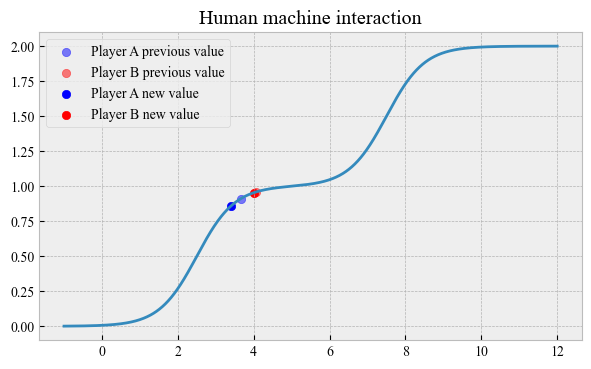

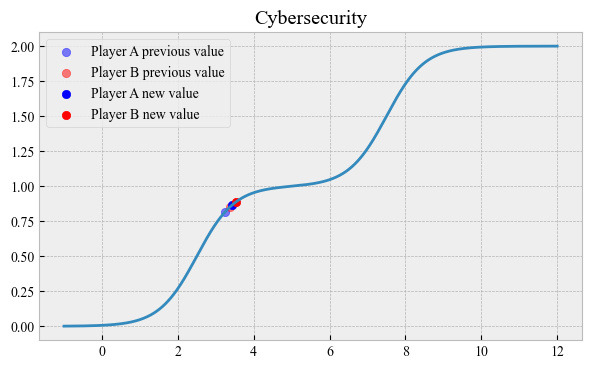

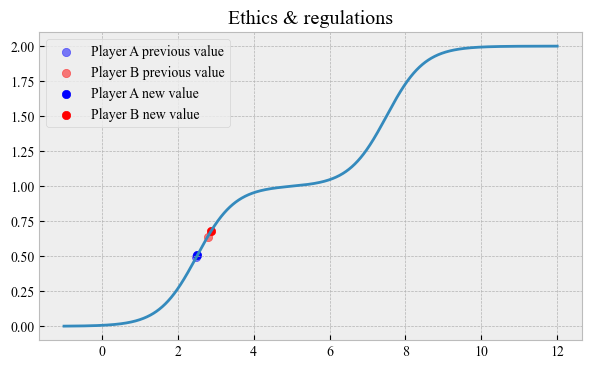

In [21]:

print(df.columns)
numPoints = len(df.index)
old_state_i = df.Parent_id
states =df.State
actions = df.Action

print(leaf_nodes)
# plot_ind = df.Node_id.max()

p_id = np.random.choice(leaf_nodes)
print(p_id)
old_state =  torch.tensor(df[df.Node_id == p_id].State.values.tolist()).squeeze()

new_state =  torch.tensor(states[plot_ind]).squeeze()

act = torch.tensor(actions[plot_ind]).squeeze()
# plot_act_theta(new_state, act, plot_ind)
plot_trl(old_state,new_state, "Technology research progress throughout full simulation", "TRL_fullGame")

# print(old_state)
# print(new_state)
# print(act)

In [20]:
np.random.choice(leaf_nodes)

65

In [ ]:
# (.values.astype(np.float32))

acts = torch.tensor(df.Action.dropna().values.tolist())
# Vals.shape
# Vals[:,game.N_Technologies:]
def update_projection(ax, axi, projection='3d', fig=None):
    if fig is None:
        fig = plt.gcf()
    rows, cols, start, stop = axi.get_subplotspec().get_geometry()
    ax.flat[start].remove()
    ax.flat[start] = fig.add_subplot(rows, cols, start+1, projection=projection)

In [ ]:
# num
def one_sided_pca_plot(df, key, t_max, fileName = None):
    
    if t_max:
        df = df[df.Time == df.Time.max()]
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
    
    
    
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            # print(vals.shape)
            nTech = int(vals.shape[1] / 2)
            
            # a = vals[i,:nTech].T
            # b = vals[i,nTech:].T
            # print(a,b)
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.techToParams(state).numpy()
            thetas.append(th[:,0])            
            thetas.append(th[:,1])
            allVals = thetas
    else:
       
        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),0)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit_AB = pca.fit_transform(allVals)
    
    pca_fit_A = pca_fit_AB[:numVals,:]
    pca_fit_B = pca_fit_AB[numVals:,:]

    fig, ax = plt.subplots(1,2,figsize=(16,4), width_ratios=(1,2))
    
    update_projection(ax,ax.flat[0],"3d")
    ax1, ax2 = ax
    # fix , axs = plt.subplots(1,2,width_ratios=(1,3))
    # ax = axs[0]
    # if t_max:
    #     fig.suptitle(f"{numVals} {key}s in last time-step")
    # else:
    #     fig.suptitle(f"{numVals} {key}s")
        
    # ax = fig.add_subplot(1,2, 1 ,projection='3d')

    ax1.scatter(pca_fit_A[:,0], pca_fit_A[:,1], pca_fit_A[:,2], color="blue", label="Player A")
    ax1.scatter(pca_fit_B[:,0], pca_fit_B[:,1], pca_fit_B[:,2], color="red", label="Player B")

    ax1.set_xlabel('$PC_1$')
    ax1.set_ylabel('$PC_2$')
    ax1.set_zlabel('$PC_3$')
    
    # ax1.set_title(f"{key if  not theta else 'Battle parameter'}s projected onto PC1, PC2, PC3")
    
    ax1.legend()
    
    
    components = pca.components_
    var = pca.explained_variance_ratio_
    
    nTech = np.shape(components[0])[0]
    nComps = len(components)
   
    # ax2 = fig.add_subplot(1,2,2 )
    # ax2.set_title(f"{key if  not theta else 'BattleParam'}s, first {nComps} Principal components. \n explained variance:{np.round(var,2)}")
    
   
    width = .5
    r = np.arange(nTech)
    
    ax2.bar(r, components[0], color="blue", width=1/5,          label=f"$PC_1, {round(100 * var[0],1)} \%$")
    ax2.bar(r + width/2, components[1], color="red", width=1/5, label=f"$PC_2, {round(100 * var[1],1)} \%$")
    ax2.bar(r + width, components[2], color="green", width=1/5, label=f"$PC_3, {round(100 *var[2],1)} \%$")
    if  theta:
        ax2.set_xticks(r + width/2, paramNames, rotation = 45, ha="right", fontsize=12)
    else:
        ax2.set_xticks(r + width/2, techNames, rotation = 45, ha="right", fontsize=12)
    # ax2.set_xticklabels(labels = game.TechnologyNames)
    # ax2.set_x
    ax2.legend(loc = "upper left")
    
    
    
    plot_or_show(fig,fileName, None)
    # if fileName is not None:
    #     fig.savefig(os.path.join("figures", fileName, ".pdf"), format = "pdf")
    # else:
    #     fig.show()
    #     fig.tight_layout(h_pad = 0, pad=0)

    

one_sided_pca_plot(df, "Action",False,"onesidede_PCA_all_action")
one_sided_pca_plot(df, "Action", True, "onesided_PCA_last_action")
one_sided_pca_plot(df, "State", False, "onesided_PCA_all_state"  )
one_sided_pca_plot(df, "State",  True,  "onesided_PCA_last_state" )
one_sided_pca_plot(df, "Theta", False,"onesided_PCA_all_theta"  )
one_sided_pca_plot(df, "Theta",  True, "onesided_PCA_all_theta"  )

In [ ]:

    
def two_sided_pca_plot(df, key, t_max, fileName = None):
    if t_max:
        df = df[df.Time == df.Time.max()]
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
        
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            # print(vals.shape)
            nTech = int(vals.shape[1] / 2)
            
            # a = vals[i,:nTech].T
            # b = vals[i,nTech:].T
            # print(a,b)
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.flatten_var(game.techToParams(state)).numpy()
            thetas.append(th)            
            # thetas.append(th)
            allVals = thetas
    else:

        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),1)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit = pca.fit_transform(allVals)
    
    # pca_fit_A = pca_fit_AB[:numVals,:]


    fig, ax = plt.subplots(1,2,figsize=(16,4), width_ratios=(1,2))
    
    update_projection(ax,ax.flat[0],"3d")
    ax1, ax2 = ax
    # fix , axs = plt.subplots(1,2,width_ratios=(1,3))
    # ax = axs[0]
    # if t_max:
    #     fig.suptitle(f"{numVals} {key}s in last time-step")
    # else:
    #     fig.suptitle(f"{numVals} {key}s")
        
    # ax = fig.add_subplot(2,2,1  ,projection='3d')

    ax1.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2], color="green")

    ax1.set_xlabel('$PC_1$')
    ax1.set_ylabel('$PC_2$')
    ax1.set_zlabel('$PC_3$')
    
    # ax1.set_title(f"{key if  not theta else 'BattleParams'}s projected onto PC1, PC1, PC3")
    
    ax1.legend()
    
    
    components = pca.components_
    var = pca.explained_variance_ratio_
    
    nTech = np.shape(components[0])[0]
    nComps = len(components)
   
    # ax2 = fig.add_subplot(2,4,3 )
    # ax2.set_title(f"{key if  not theta else 'Battle Parameter' }s, first {nComps} Principal components. \n explained variance:{np.round(var,2)}")
    
   
    width = .5
    r = np.arange(nTech)
    
    ax2.bar(r, components[0], color="blue", width=1/5,          label=f"$PC_1, {round(100 * var[0],1)} \%$")
    ax2.bar(r + width/2, components[1], color="red", width=1/5, label=f"$PC_2, {round(100 * var[1],1)} \%$")
    ax2.bar(r + width, components[2], color="green", width=1/5, label=f"$PC_3, {round(100 *var[2],1)} \%$")

    if  theta:
        ax2.set_xticks(r + width/2, paramNames * 2, rotation = 45, ha="right", fontsize=14)
    else:
        ax2.set_xticks(r + width/2, techNames * 2, rotation = 45, ha="right", fontsize=12)
    # ax2.set_xticklabels(labels = game.TechnologyNames)
    # ax2.set_x
    ax2.legend()
    
    
    
    plot_or_show(fig,fileName, None)
    # if fileName is not None:
    #     fig.savefig(os.path.join("figures", fileName, ".pdf"), format = "pdf")
    # else:
    #     fig.show()
    #     fig.tight_layout(h_pad = 0, pad=0)

    
    

two_sided_pca_plot(df,"Action", False, "twosided_PCA_all_action")
two_sided_pca_plot(df,"Action", True ,"twosided_PCA_last_action")
two_sided_pca_plot(df,"State", False, "twosided_PCA_all_state")  
two_sided_pca_plot(df,"State", True,  "twosided_PCA_last_state")
two_sided_pca_plot(df, "Theta", False,"twosided_PCA_all_theta"  )
two_sided_pca_plot(df, "Theta", True, "twosided_PCA_all_theta" )

In [ ]:
lower = 0 
upper = 12
numPoints = 20
ranges = [np.linspace(lower,upper,numPoints) for _ in range(2*nTech)]
# [_ for _ in ranges[0]]
# grids = np.mgrid(ranges)

# for points in zip(grids):
#     print(points)

In [ ]:
import itertools
lower = 1 
upper = 12

numPoints = 100
nParams = 10
numReps = 1
for vals in itertools.combinations_with_replacement(range(lower,upper,numPoints),10):
    print(vals)
    # thetaA = [6] + list(vals[:5]) + [1/3, 1]
    # thetaB = [6] + list(vals[5:]) + [1/3, 1]
    # theta_list = torch.tensor(thetaA + thetaB)
    # print(theta_list)

    # theta = torch.stack((theta_list[:8], theta_list[8:]), dim=1).squeeze()
    # try:
    #     score = np.mean([game.SalvoBattleSequential(theta).numpy() for _ in range(numReps)])
    # except AssertionError:
    #     score = None
    # print(score)
    

In [ ]:

for vals in itertools.combinations_with_replacement(range(lower,25,numPoints),10):
    print(vals)

In [ ]:
def theta_pca_score(df, fileName = None):
    key = "Theta"
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
        
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            
            
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.flatten_var(game.techToParams(state)).numpy()
            thetas.append(th)            
            # thetas.append(th)
            allVals = thetas
    else:

        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),1)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit = pca.fit_transform(allVals)
    print(len(allVals))
    
    
    scores = df["Reward"].tolist()
    hi = max(scores)
    lo = min(scores)
    # print(hi, lo)
    green = np.array([0, 255, 0, 0.75*255])/255
    red =  np.array([255, 0, 0, 0.75*255])/255
    standardizedScores = [(s-lo)/(hi-lo) for s in scores]
    # print(standardizedScores)
    colors = [green * ss + red * ( 1 - ss) for ss in standardizedScores ]
    # print(colors)
    
    
    
    fig, axs = plt.subplots(1,1,subplot_kw={"projection": "3d"}, figsize=(6,6))
    # fig.set
    # update_projection(axs,axs.flat[0])
    # fig.suptitle(f"low:{round(lo,3)}, high:{round(hi,3)}")
    
    # ax = axs[0]
    ax = axs
    ax.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2], color = colors)

    ax.set_xlabel('$PC_1$')
    ax.set_ylabel('$PC_2$')
    ax.set_zlabel('$PC_3$')

    # fig.colorbar(scores,ax=ax)


    plot_or_show(fig,fileName)
    
    # if fileName is not None:
    #     fig.savefig(os.path.join("figures", fileName, ".pdf"), format = "pdf")
    # else:
    #     fig.show()
    #     fig.tight_layout(h_pad = 0, pad=0)
    
    
theta_pca_score(df.loc[1:,:], "PCA_theta_score")

In [ ]:
df.shape

In [ ]:
def all_pca_plot(df, key, t_max=False, fileName = None):
    if t_max:
        df = df[df.Time == df.Time.max()]
    if key == "theta":
        vals = torch.tensor(getattr(df, "State").dropna().values.tolist())
        thetas = []
        for i in range(max(vals.size)):
            
            
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.flatten_var(game.techToParams(state)).numpy()
            thetas.append(th)            
            thetas.append(th)
        vals = thetas
        vals
    else:
        
        vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    
        # print(vals)
        numVals = vals.shape[0]
        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()

    # print(valsA, valsB)
    pca = sklearn.decomposition.PCA()
    pca_fit_AB = pca.fit_transform(np.concatenate((valsA,valsB),0))
    
    evr = pca.explained_variance_ratio_
    
    fig, ax = plt.subplots(1,1)
    # ax.set_title(f"explained variance of PC, {key}")
    ax.bar(range(pca.n_components_),evr, label="per $PC$")
    ax.plot(range(pca.n_components_),np.cumsum(evr), label ="cummulative sum")
    
    ax.set_xlabel("$PC_n$")
    ax.set_ylabel("explained variance, ratio")
    ax.legend(loc="best")    
    print(np.cumsum(evr)[2])
    plot_or_show(fig,fileName)
    # if fileName is not None:
    #     fig.savefig(os.path.join("figures", fileName, ".pdf"), format = "pdf")
    # else:
    #     fig.show()
    #     fig.tight_layout(h_pad = 0, pad=0)

all_pca_plot(df, "Action", False, "explained_variance_all_action")
all_pca_plot(df, "Action", True, "explained_variance_last_action")
all_pca_plot(df, "State", False, "explained_variance_all_state")
all_pca_plot(df, "State", True, "explained_variance_last_state")
# all_pca_plot(df, "Theta", False)
# all_pca_plot(df, "Theta", True)

In [ ]:
def onePlayer_pca_plot(df, key, t_max=False, player = 0, fileName = None):
    if t_max:
        df = df[df.Time == df.Time.max()]
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    
    
    # print(vals)
    numVals = vals.shape[0]
    valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()

    # print(valsA, valsB)
    pca = sklearn.decomposition.PCA()
    # pca_fit_AB = pca.fit_transform(np.concatenate((valsA,valsB),0))
    if player == 0:    
        pca_fit = pca.fit_transform(valsA,0)
    elif player == 1:
        pca_fit = pca.fit_transform(valsB,0)
    
    # pca_fit.explain_variance_raito_
    evr = pca.explained_variance_ratio_
    
    fig, ax = plt.subplots(1,1)
    # ax.set_title(f"explained variance of PC, {key}")
    ax.bar(range(pca.n_components_),evr, label="per $PC$")
    ax.plot(range(pca.n_components_),np.cumsum(evr), label ="cummulative sum")
    
    ax.set_xlabel("$PC_n$")
    ax.set_ylabel("explained variance, ratio")
    ax.legend(loc="best")    
    # ax.axvline(2)
    plot_or_show(fig,fileName, "EXPLAINED_VARIANCE")
    # if fileName is not None:
    #     fig.savefig(os.path.join("figures", fileName, ".pdf"), format = "pdf")
    # else:
    #     fig.show()
    #     fig.tight_layout(h_pad = 0, pad=0)

# all_pca_plot(df, "Action", False,0, "explained_variance_all_action")
# all_pca_plot(df, "Action", True,0 "explained_variance_last_action")
all_pca_plot(df, "State", False, "explained_variance_all_state")
onePlayer_pca_plot(df, "State", False, 0,"explained_variance_last_state")
onePlayer_pca_plot(df, "State", False, 1,"explained_variance_last_state")

# all_pca_plot(df, "Theta", False)
# all_pca_plot(df, "Theta", True)

In [ ]:
## Total capital invested normalised
Budget = [1,1]
nTech
actions = torch.tensor(df.Action[1:].values.tolist())
actionsA = actions[:,:nTech]
actionsB = actions[:,nTech:]

meansA = actionsA.mean(dim=0)
meansB = actionsB.mean(dim=0)

fig, ax = plt.subplots(1,1)
# ax2 = fig.add_subplot(1,2,2 )
# ax.set_title(f"Average investment per technology per player")


width = .5
r = np.arange(nTech)

ax.bar(r - width/3, meansA, color="blue", width=1/3, label="Player A")
ax.bar(r + width/3, meansB, color="red", width=1/3, label="Player B")
ax.set_xticks(r, techNamesFull, rotation = 45, ha="right")
ax.scatter(r,game.PARAMCONVERSIONMATRIX.sum(axis=0)/game.PARAMCONVERSIONMATRIX.sum(axis=0).sum(), color="black", label="Share of weights in $C$")
ax.legend()
# ax.bar(r + width, components[2], color="green", width=1/5, label="PC3")
# if  theta:
#     ax2.set_xticks(r + width/2, game.ParamNames * 2, rotation = 45, ha="right")
# else:
#     ax2.set_xticks(r + width/2, game.TechnologyNames * 2, rotation = 45, ha="right")
# ax2.set_xticklabels(labels = game.TechnologyNames)
# ax2.set_x
# ax2.legend()


plot_or_show(fig,"average_investment_technologies")
# fig.tight_layout(h_pad = 0, pad=0)
# fig.show()
# fig.savefig(os.path.join("figures", "average_investment_technologies", ".pdf"), format = "pdf")

In [ ]:
## Total capital invested normalised
Budget = [1,1]
C = game.PARAMCONVERSIONMATRIX
C_comp = game.PARAMCONVERSIONMATRIX.sum(axis=1)/game.PARAMCONVERSIONMATRIX.sum()

actions = torch.tensor(df.Action[1:].values.tolist(),dtype=torch.double)

actionsA = actions[:,:nTech]
actionsB = actions[:,nTech:]

deltaThetaA = C @ actionsA.T
deltaThetaB = C @ actionsB.T
# print(deltaThetaA.size())

deltaThetaA_means = deltaThetaA.mean(dim=1)
deltaThetaA_means = deltaThetaA_means / deltaThetaA_means.sum()
deltaThetaB_means = deltaThetaB.mean(dim=1)
deltaThetaB_means = deltaThetaB_means / deltaThetaB_means.sum()

# meansA = actionsA.mean(dim=0)
# meansB = actionsB.mean(dim=0)

fig, ax = plt.subplots(1,1)
# ax2 = fig.add_subplot(1,2,2 )
# ax.set_title(f"Average parameter impact of investments  per player")


width = .5
r = np.arange(len(paramNames))

ax.bar(r - width/3, deltaThetaA_means, color="blue", width=1/3, label="Player A")
ax.bar(r + width/3, deltaThetaB_means, color="red", width=1/3, label="Player B")
ax.set_xticks(r, paramNames, rotation = 45, ha="right", fontsize=14)
ax.scatter(r,C_comp, color="black", label="Share of weights in $C$")
ax.legend()
# ax.bar(r + width, components[2], color="green", width=1/5, label="PC3")
# if  theta:
#     ax2.set_xticks(r + width/2, game.ParamNames * 2, rotation = 45, ha="right")
# else:
#     ax2.set_xticks(r + width/2, game.TechnologyNames * 2, rotation = 45, ha="right")
# ax2.set_xticklabels(labels = game.TechnologyNames)
# ax2.set_x
# ax2.legend()


fig.tight_layout(h_pad = 0, pad=0)
# fig.show()
plot_or_show(fig,"average_investment_params")
# fig.savefig(os.path.join("figures", "average_investment_params", ".pdf"), format = "pdf")

In [ ]:
print(deltaThetaB_means, "\n",
    paramNames)
print(nParams)

In [ ]:
C.size()

In [ ]:
trajectories = []
pca = sklearn.decomposition.PCA(3)
vals = torch.tensor(getattr(df, "State").dropna().values.tolist())
valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
allVals = np.concatenate((valsA,valsB),0)
# print(allVals.shape)
pca.fit(allVals)
states_A_pca = pca.transform(valsA)
states_B_pca = pca.transform(valsB)

# pca_fit = pca.fit_transform(allVals)

def get_trajectory(df, node_id):
    node_ids = [node_id]

    while node_id  != 0:
        node_id = int(df[df.Node_id == node_id].Parent_id.values[0])
        node_ids.append(node_id)
    # node_ids.append(0)
    return node_ids

leaf_nodes = df[df.Time == df.Time.max()].Node_id.values.tolist()
leaf_nodes
trajectories = []
for l_id in leaf_nodes:
    traj =  get_trajectory(df, node_id=l_id)
    # print(traj)
    trajectories.append(traj)
    
states = torch.Tensor(df[df.Node_id.isin(traj)].State.values.tolist())
# print(states.shape)
# statesA = states[:,:nTech].numpy()
# statesB = states[:,nTech:].numpy()
# statesA = pca.transform(statesA).tolist()
# statesB = pca.transform(statesB).tolist()

numPlots = min(len(trajectories),15)


sample_idx = random.sample(range(len(trajectories)),numPlots)
print(sample_idx)
for i in range(numPlots):
    fig, ax = plt.subplots(1,1,figsize=(6,6), subplot_kw= {"projection" : "3d"})
    idx = sample_idx[i]
    print(idx)
    traj = trajectories[idx]

    # iterating over grid

    ax.set_xlabel('$PC_1$')
    ax.set_ylabel('$PC_2$')
    ax.set_zlabel('$PC_3$')

    # ax.set_xlim3d((-25,25))
    # ax.set_ylim3d((-100,100))
    # ax.set_zlim3d((-50,50))    

    print(traj)
    states_A_pca_traj = states_A_pca[traj]
    states_B_pca_traj = states_B_pca[traj]
    # print(states_B_pca_traj)
    # print(states_A_pca_traj)
    # print(states_A_pca_traj[:,0])
    l = len(states_A_pca_traj)
    # print(l)
    markers = tuple(['s'] + ['o']*(l-2) + ['>'])
    ax.set_title(f"Trajectory with end state: {idx}")
    ax.plot(states_A_pca_traj[:,0], states_A_pca_traj[:,1], states_A_pca_traj[:,2], color="blue", label="Player A")#, marker=markers)
    ax.plot(states_B_pca_traj[:,0], states_B_pca_traj[:,1], states_B_pca_traj[:,2], color="red", label ="Player B")#, marker=markers)

    for j in range(len(traj)):
        if j == 0:
            label = "stop"
        elif j == (len(traj) - 1):
            label ="start"
        else:
            label = None
            
        ax.scatter(states_A_pca_traj[j,0], states_A_pca_traj[j,1], states_A_pca_traj[j,2], color="blue", marker=markers[j])#, label=label)
        ax.scatter(states_B_pca_traj[j,0], states_B_pca_traj[j,1], states_B_pca_traj[j,2], color="red", marker=markers[j])#, label=label)
        ax.legend()
    # ax.show()
    plot_or_show(fig,"trajectories"+"_"+str(i), "TRAJECTORIES")
    # fig.savefig(os.path.join("figures", "trajectories", ".pdf"), format = "pdf")

In [ ]:
plt.scatter(df.Time, df.Reward)